In [126]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import os
import networkx as nx
from scipy import interpolate
import gc
import matplotlib.colors as mcolors
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()

In [2]:
torch.cuda.empty_cache()
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)
print('loaded!')

loaded!


In [3]:
token_data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/resources/token_mapping.csv"
token_df = pd.read_csv(token_data_path)
token_df.head()

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
0,<pad>,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,<mask>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,ENSG00000000003,2,TSPAN6,2.001186,15.0,protein_coding,X,100627107.0,100639991.0,False
3,ENSG00000000005,3,TNMD,3.228213,6.0,protein_coding,X,100584935.0,100599885.0,False
4,ENSG00000000419,4,DPM1,2.218874,14.0,protein_coding,20,50934866.0,50959140.0,False


# load the data

In [37]:
def load_data(path, sample_size=None):
    """
    Loads data from a file, processes cell types, and returns a DataFrame.

    Args:
        path (str): The path to the dataset file.
        sample_size (int, optional): Number of cells to sample. Defaults to None.
    Returns:
        pandas.DataFrame: The processed DataFrame.
    """

    df = gtu.load_data_as_dataframe(path, num_cells=sample_size)

    if "iHSC" in path:
        df['cell_type'] = "iHSC"
    elif "pellin" in path:
        df['cell_type'] = df['dataset']
    elif "weng" in path:
        df['cell_type'] = df['STD.CellType']
    else:
        df['cell_type'] = df['free_annotation']

    # Extract basename without extension and assign to 'dataset' column
    df['dataset'] = os.path.splitext(os.path.basename(path))[0]
    df = df[['input_ids', 'cell_type', 'dataset', 'length']]

    return df

def add_sequential_id(df):
    """Adds a new column named 'id' with sequential identifiers starting from 1.

    Args:
        df (pandas.DataFrame): The DataFrame to add the 'id' column to.

    Returns:
        pandas.DataFrame: The DataFrame with the added 'id' column.
    """
    df['cell_id'] = range(1, len(df) + 1)
    df['cell_id'] = "cell_" + df['cell_id'].astype(str)
    return df

data_paths = [
    "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/iHSC.dataset",   
    "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset",   
    "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/weng_young2_HSC.dataset",   
]

df = []

for path in data_paths:
    tmp = load_data(path)
    df.append(tmp)
    
df = pd.concat(df)
df = add_sequential_id(df)
print(f"{df.shape=}")

# print value counts
df['cell_type'].value_counts()

df.shape=(28314, 5)


cell_type
iHSC                          8574
fibroblast                    5867
macrophage                    3301
HSC                           3243
smooth muscle cell            3075
endothelial cell              1564
pericyte cell                 1193
t cell                         476
MPP                            396
artery endothelial cell        138
nk cell                        121
mast cell                      105
MKP                             64
erythrocyte                     64
lymphatic endothelial cell      44
plasma cell                     42
epithelial cell                 26
b cell                          21
Name: count, dtype: int64

In [35]:
def get_gene_tokens(token_df, gene_names):
    """
    Extracts the token IDs of specified genes from a DataFrame.

    Args:
      token_df (pandas.DataFrame): The DataFrame containing gene information.
      gene_names (list): A list of gene names to extract.

    Returns:
      list: A list of token IDs corresponding to the specified genes.
    """
    genes = token_df[token_df['gene_name'].isin(gene_names)]
    return genes['token_id'].to_list()

gene_names = [
    # 'MYOD1',
    'GATA2',
    'FOS',
    'GFI1B',
]

factors = get_gene_tokens(token_df, gene_names)
factors

[11599, 12698, 14409]

In [38]:
def perturb_data(df, tokens):
    """
    Perturbs the input_ids in a DataFrame by prepending a list of tokens.

    Args:
      df (pandas.DataFrame): The input DataFrame with an 'input_ids' column.
      tokens (list): The list of tokens to prepend.

    Returns:
      pandas.DataFrame: The combined DataFrame with original and perturbed data.
    """

    perturbed = df.copy()
    perturbed['state'] = 'perturbed'
    perturbed['input_ids'] = perturbed['input_ids'].apply(
      lambda x: list(tokens) + list(x)[:len(x) - len(tokens)]
    )

    df['state'] = 'raw'
    combined_df = pd.concat([df, perturbed])
    return combined_df


sample_size = 5
initial_cell_type = "fibroblast"
pdf = df[df['cell_type'] == initial_cell_type].sample(sample_size)
print(f"{pdf.shape=}")

pdf = perturb_data(pdf, factors)
pdf

pdf.shape=(5, 5)


,input_ids,cell_type,dataset,length,cell_id,state
2135,"[16916, 3992, 9103, 7414, 8578, 18367, 19437, ...",fibroblast,TS_Vasculature,2048,cell_10710,raw
1238,"[3878, 376, 8654, 16916, 18367, 1404, 9009, 19...",fibroblast,TS_Vasculature,2048,cell_9813,raw
12693,"[5592, 2649, 15960, 16876, 4415, 10920, 11411,...",fibroblast,TS_Vasculature,2048,cell_21268,raw
5434,"[16916, 9009, 3878, 10945, 16345, 16876, 454, ...",fibroblast,TS_Vasculature,2048,cell_14009,raw
14681,"[16916, 12119, 16876, 9009, 2522, 303, 18367, ...",fibroblast,TS_Vasculature,2048,cell_23256,raw
2135,"[11599, 12698, 14409, 16916, 3992, 9103, 7414,...",fibroblast,TS_Vasculature,2048,cell_10710,perturbed
1238,"[11599, 12698, 14409, 3878, 376, 8654, 16916, ...",fibroblast,TS_Vasculature,2048,cell_9813,perturbed
12693,"[11599, 12698, 14409, 5592, 2649, 15960, 16876...",fibroblast,TS_Vasculature,2048,cell_21268,perturbed
5434,"[11599, 12698, 14409, 16916, 9009, 3878, 10945...",fibroblast,TS_Vasculature,2048,cell_14009,perturbed
14681,"[11599, 12698, 14409, 16916, 12119, 16876, 900...",fibroblast,TS_Vasculature,2048,cell_23256,perturbed


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [4482, 11558, 9451, 12311, 11147]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


embs.shape=(1000, 512)


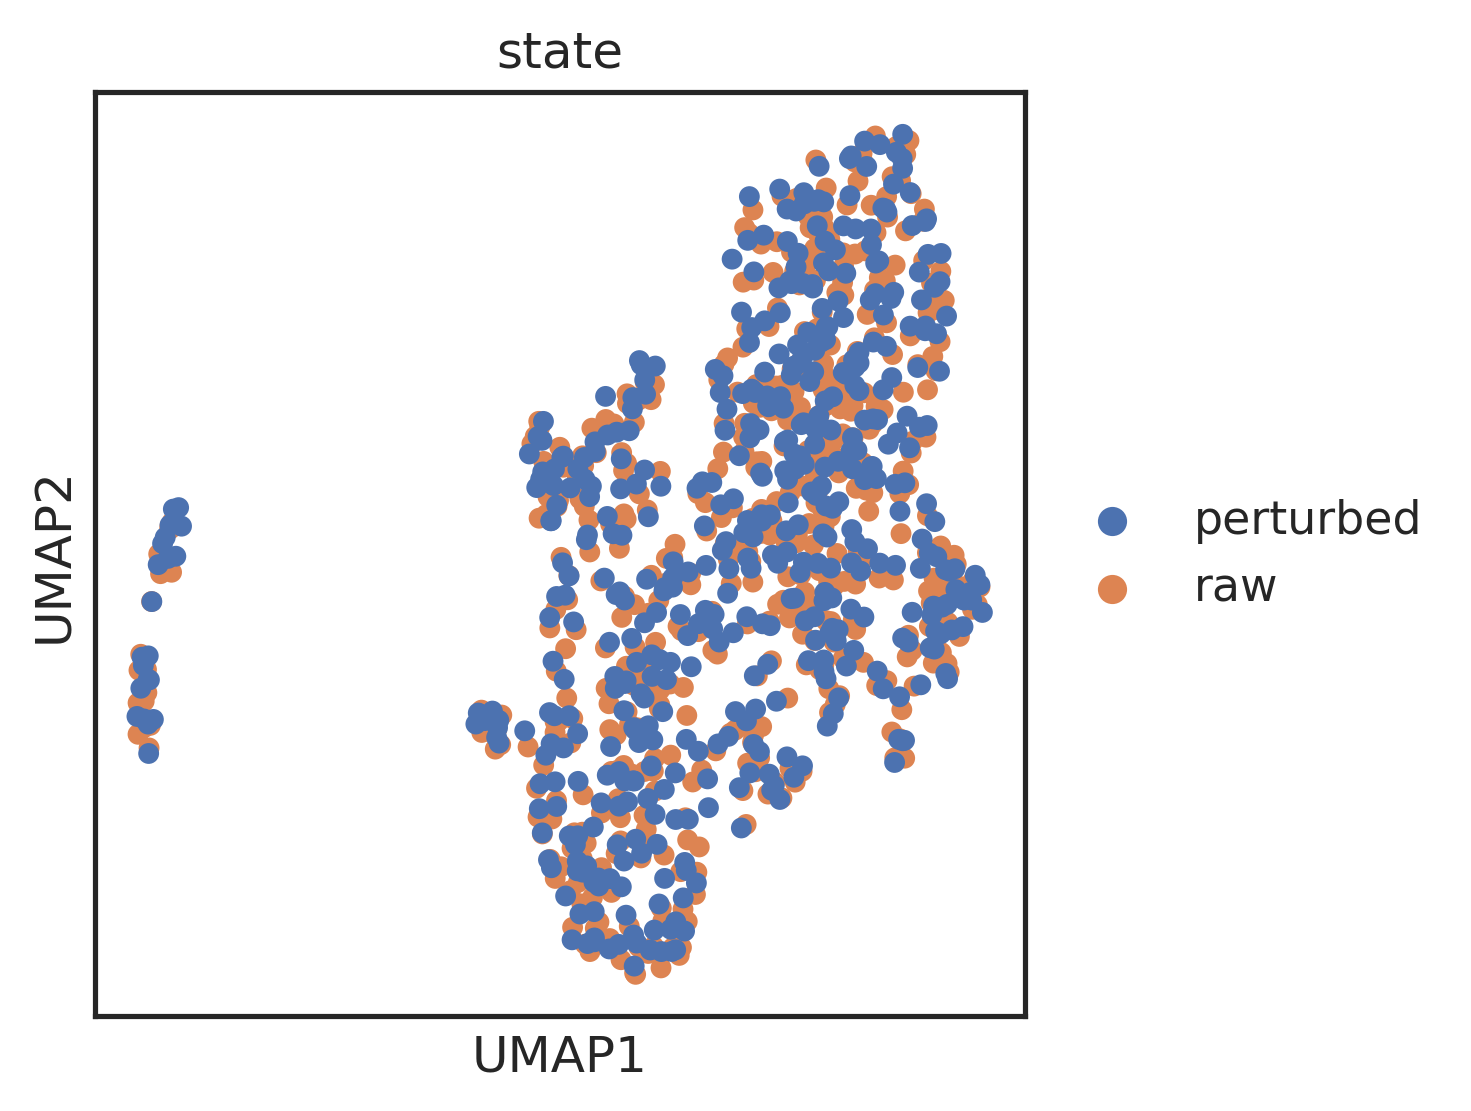

In [193]:
sample_size = 500
initial_cell_type = "fibroblast"
pdf = df[df['cell_type'] == initial_cell_type].sample(sample_size)
pdf = perturb_data(pdf, factors)

data = Dataset.from_pandas(pdf)
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = pdf.copy()

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["state"],
    ncols=1,
    size=100,
)

# make the plotting data
plot_df = adata.obs.copy()
plot_df['UMAP 1'] = adata.obsm['X_umap'][:, 0]
plot_df['UMAP 2'] = adata.obsm['X_umap'][:, 1]

/tmp/ipykernel_2849199/3626136973.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cell, group in df.groupby('cell_id'):
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


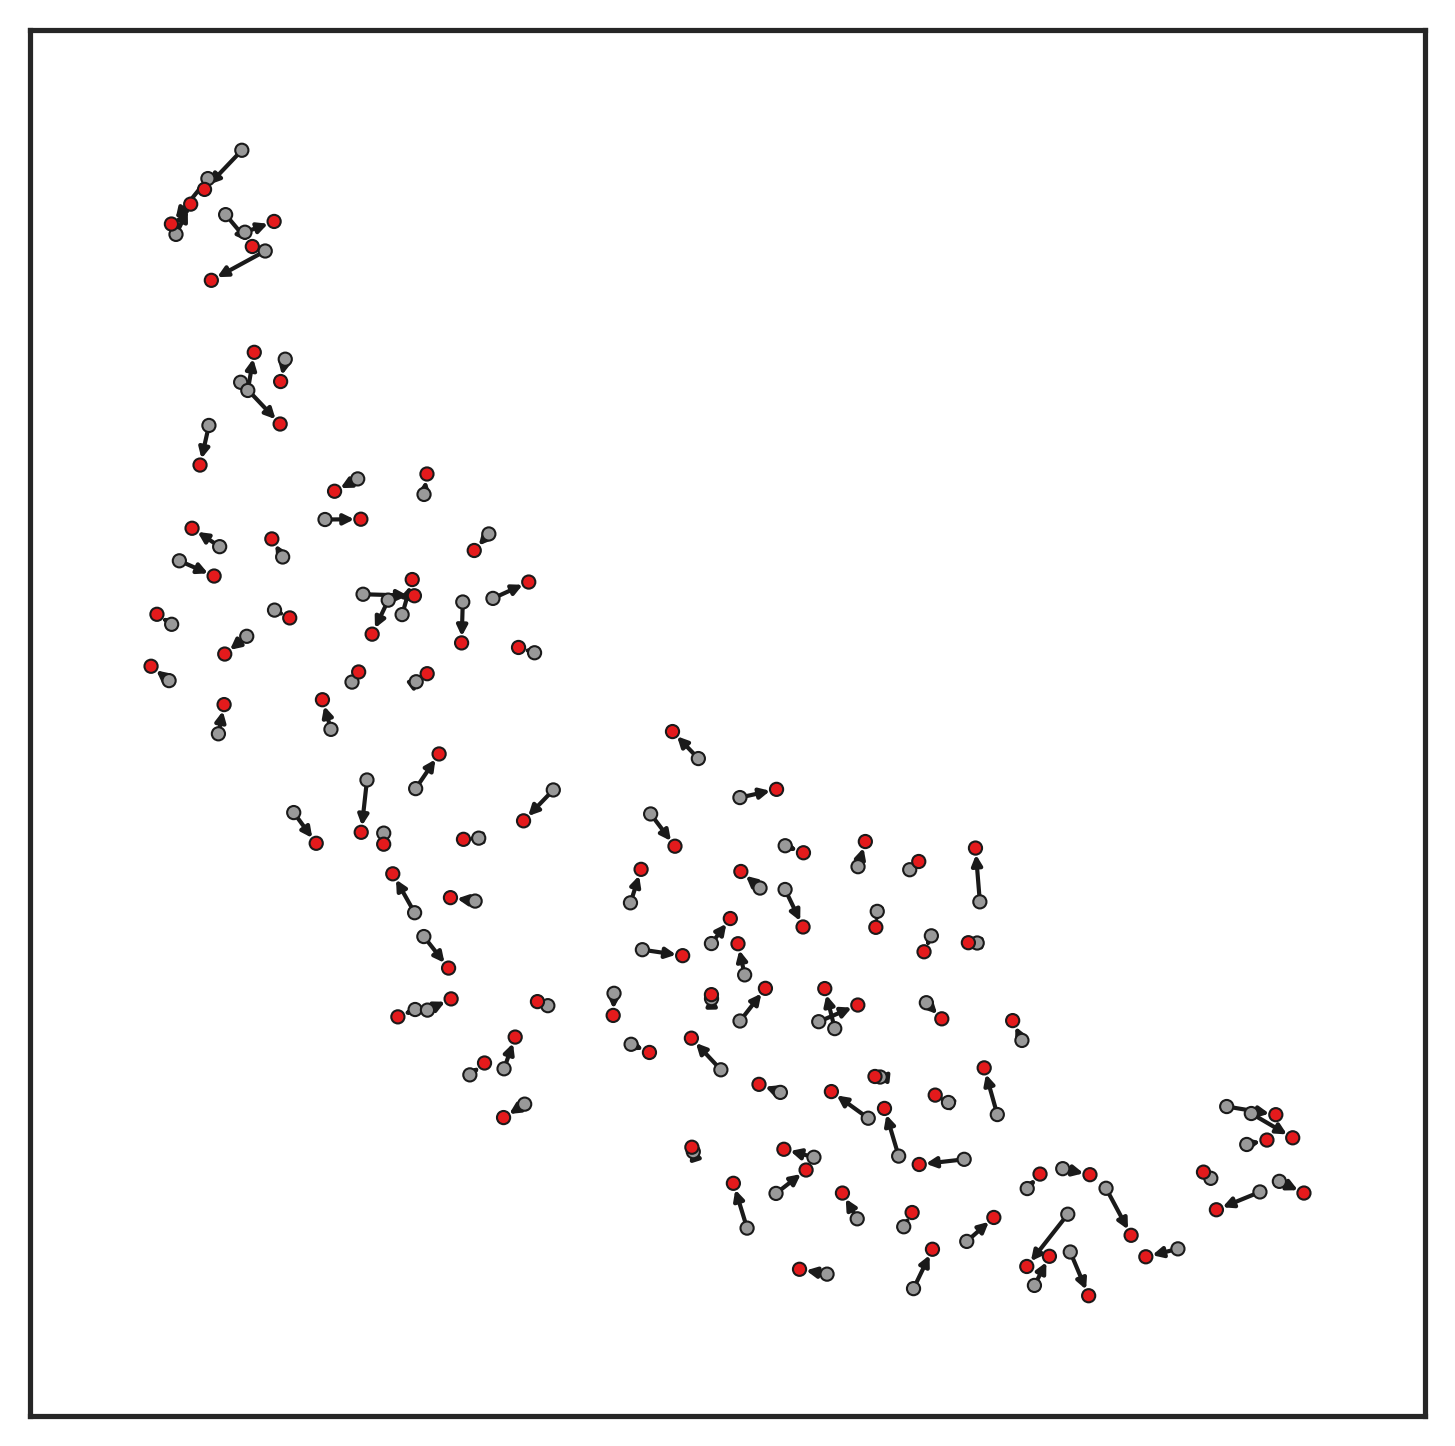

In [148]:
def get_hex_colors_for_strings(strings, cmap_name='tab10'):
    """Generates a list of hex color codes corresponding to strings using a matplotlib colormap.

    Args:
        strings (list): List of strings.
        cmap_name (str, optional): Name of the matplotlib colormap to use. Defaults to 'tab10'.

    Returns:
        list: List of hex color codes (e.g., '#RRGGBB') with the same length as the input 'strings'.
    """
    cmap = plt.get_cmap(cmap_name)  # Load the colormap
    unique_strings = list(set(strings))

    # Handle cases where there are more unique strings than colors in the colormap
    if len(unique_strings) > cmap.N:
        cmap = cmap.resampled(len(unique_strings))  # Resample for more colors

    # Create a mapping between unique strings and their corresponding colors
    normalized_values = [i / (len(unique_strings) - 1) for i in range(len(unique_strings))]
    color_map = {string: mcolors.to_hex(cmap(value)) for string, value in zip(unique_strings, normalized_values)}

    # Map the colors back to the original string list
    return [color_map[string] for string in strings]


def plot_perturbation(df, cmap='Set1'):
    """
    Plots perturbations on a UMAP projection.

    Args:
        df (DataFrame): Data containing 'UMAP 1', 'UMAP 2', 'state', and 'cell_type' columns.
        cmap (str, optional): Colormap for states. Defaults to 'Set1'.

    Returns:
        None: Displays the plot.
    """

    G = nx.DiGraph()
    df = df.reset_index(drop=True)

    for idx, row in df.iterrows():
        G.add_node(
            idx,
            pos=(row["UMAP 1"], row["UMAP 2"]),
            state=row["state"],
            cell_type=row["cell_type"],
        )

    for cell, group in df.groupby('cell_id'):
        raw = group[group['state'] == 'raw'].index.values[0]
        perturbed = group[group['state'] == 'perturbed'].index.values[0]
        G.add_edge(raw, perturbed)

    pos = nx.get_node_attributes(G, 'pos')
    colors = get_hex_colors_for_strings(list(nx.get_node_attributes(G, 'state').values()), cmap_name=cmap)  # Assuming get_hex_colors_for_strings is defined elsewhere

    nx.draw_networkx(
        G,
        pos,
        node_color=colors,
        node_shape='o',
        alpha=1,
        node_size=10,
        edgecolors='k',
        linewidths=0.5,
        with_labels=False,
        font_color='k',
        font_size=4,
        font_family='sans-serif',
        font_weight='bold',
        horizontalalignment='center',
        verticalalignment='center',
        edge_color='k',
        arrows=True,
        arrowsize=5,
    )
    plt.show()  # Display the plot
    

plot_perurbation(plot_df)

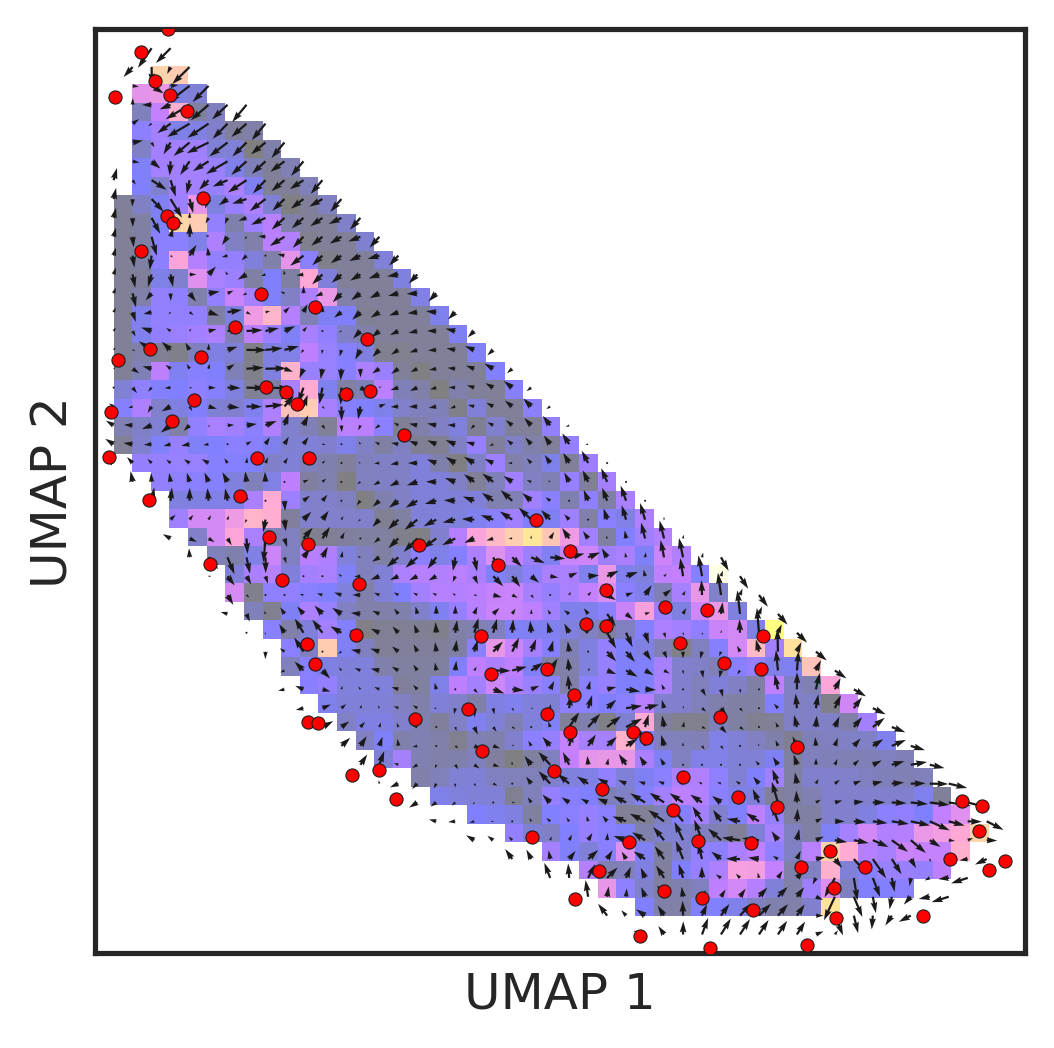

In [192]:
def plot_cell_scatter_interpolated_vector_field(df, n=50, cmap='gnuplot2', **kwargs):
    """
    Creates a scatterplot of cells using Seaborn, colored by state,
    with an interpolated vector field representing perturbations.

    Args:
        df: A pandas DataFrame with columns 'input_ids', 'cell_type', 'dataset',
            'length', 'cell_id', 'state', 'UMAP 1', 'UMAP 2'.
        n: Number of grid points in each dimension for interpolation.
        cmap: Colormap for the vector field magnitude visualization.
        **kwargs: Additional keyword arguments to pass to seaborn.scatterplot().
    """

    # Merge dataframes to ensure pairs exist
    df_merged = df[df['state'] == 'raw'].merge(
        df[df['state'] == 'perturbed'], on='cell_id', suffixes=('_raw', '_perturbed')
    )

    # Prepare vector field data
    X = df_merged['UMAP 1_raw']
    Y = df_merged['UMAP 2_raw']
    U = df_merged['UMAP 1_perturbed'] - df_merged['UMAP 1_raw']
    V = df_merged['UMAP 2_perturbed'] - df_merged['UMAP 2_raw']

    # Create interpolation grid
    grid_x, grid_y = np.meshgrid(
        np.linspace(df['UMAP 1'].min(), df['UMAP 1'].max(), n),
        np.linspace(df['UMAP 2'].min(), df['UMAP 2'].max(), n),
    )

    # Interpolate vectors
    grid_vectors = interpolate.griddata((X, Y), np.vstack((U, V)).T, (grid_x, grid_y))

    # Calculate vector field magnitude
    gx, gy = np.gradient(grid_vectors[:, :, 0]), np.gradient(grid_vectors[:, :, 1])
    
    gx = np.flipud(gx[0])
    gy = np.flipud(gy[0])

    # Ensure gx and gy are numpy arrays and compute magnitude (corrected)
    mag = np.sqrt(np.asarray(gx) ** 2 + np.asarray(gy) ** 2) 

    # Plotting (using your preferred style)
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.facecolor'] = "w"
    plt.rcParams['figure.figsize'] = 4, 4
    fig, axs = plt.subplots()

    # Vector field with quiver
    axs.quiver(grid_x, grid_y, grid_vectors[:, :, 0], grid_vectors[:, :, 1], zorder=2)

    # Scatter plot on top
    sns.scatterplot(data=df[df['state'] == 'raw'], 
                    x='UMAP 1', 
                    y='UMAP 2', 
                    ec='k', 
                    c='red',
                    s=10,
                    ax=axs, 
                    zorder=5,
                    **kwargs)

    # Magnitude as background image
    axs.imshow(
        mag,
        cmap=cmap,
        alpha=0.5,
        zorder=1,
        extent=(
            df['UMAP 1'].min(), 
            df['UMAP 1'].max(),
            df['UMAP 2'].min(), 
            df['UMAP 2'].max(),
               )
    )

    
    # Set title and axis labels
    axs.set_xlabel('UMAP 1')
    axs.set_ylabel('UMAP 2')
    axs.set_aspect('auto')
    plt.yticks([])
    plt.xticks([])

    plt.show()
    
    
plot_cell_scatter_interpolated_vector_field(plot_df)

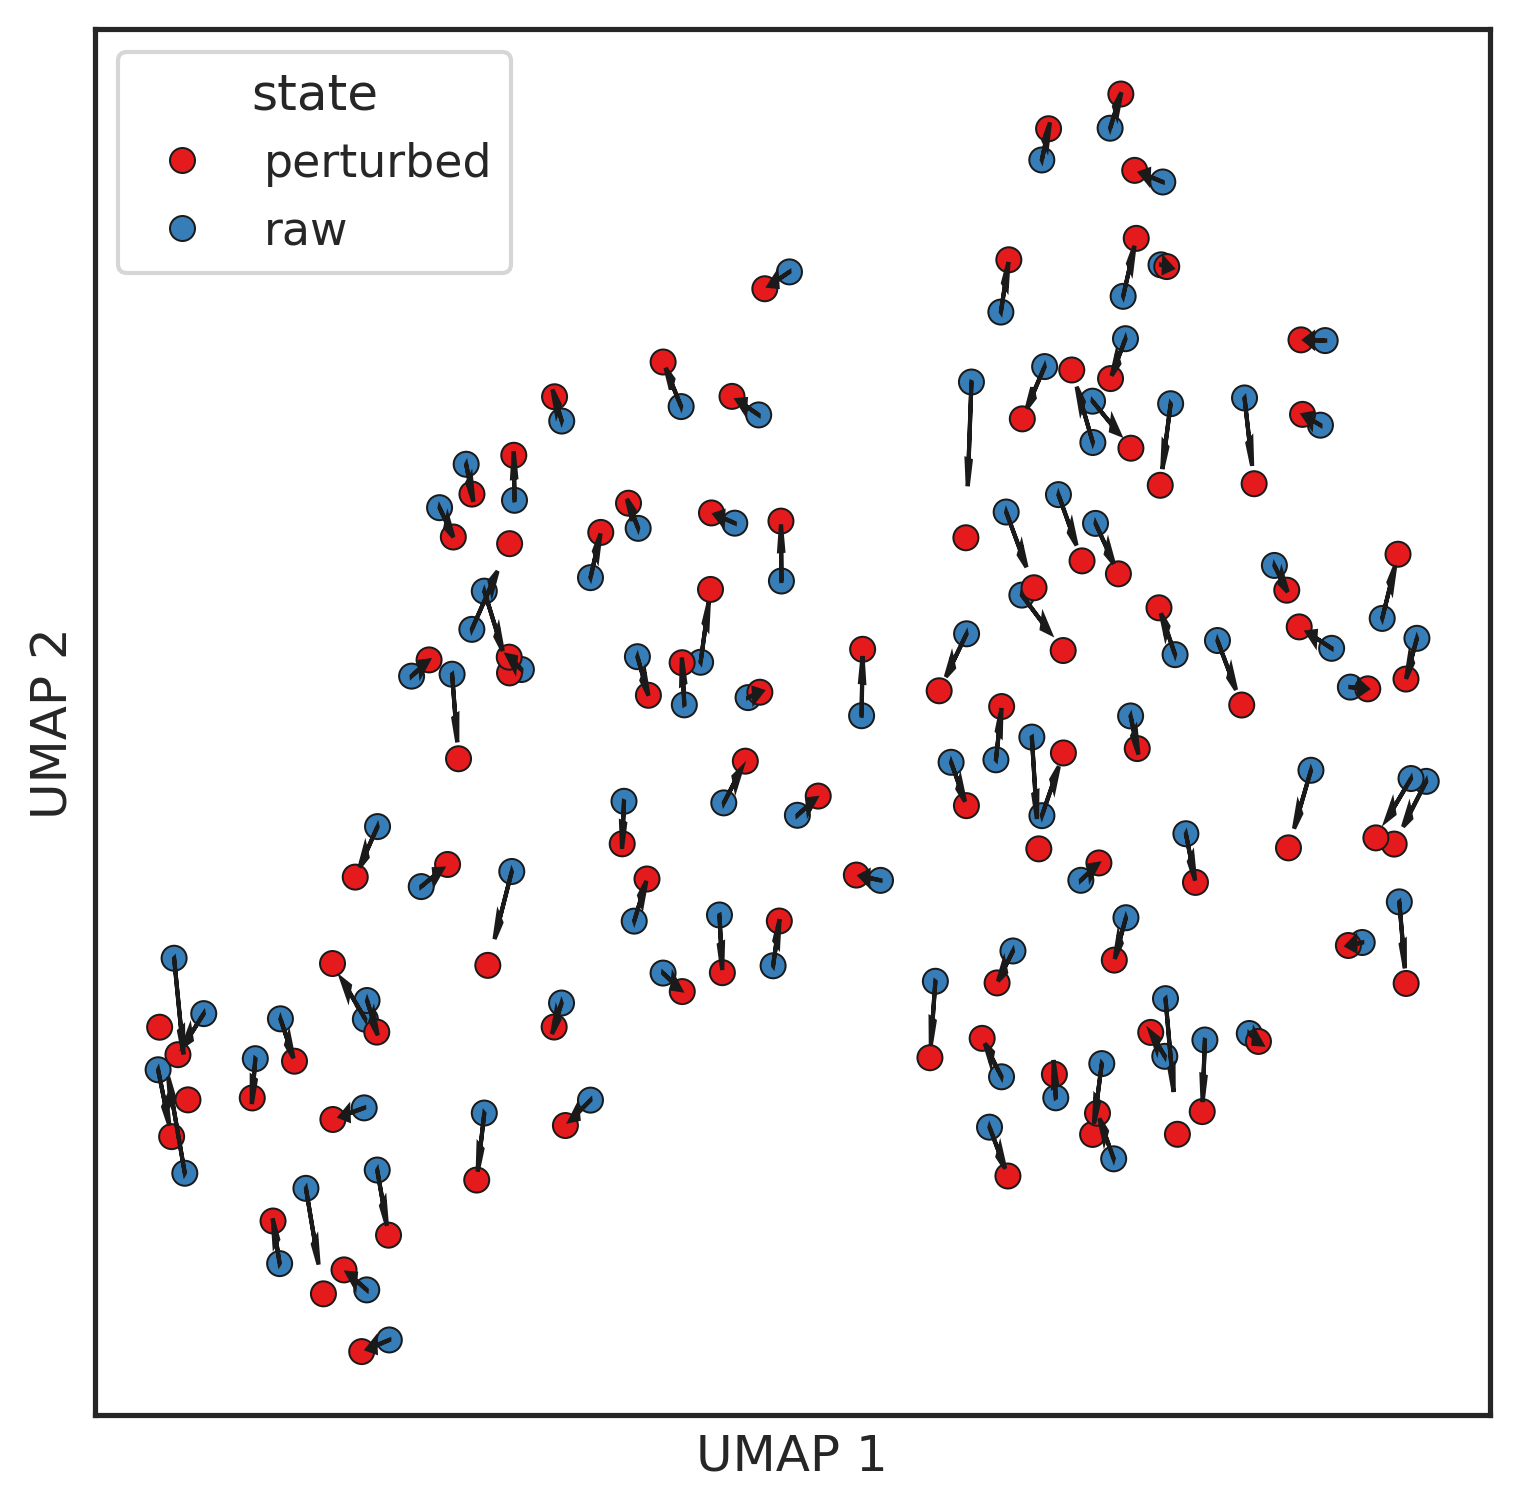

In [80]:
def plot_cell_scatter(df, arrow_kwargs={}, arrow_stop_frac=0.5, **kwargs):
    """
    Creates a scatterplot of cells using Seaborn, colored by state,
    with arrows between raw and perturbed states that stop a fraction of the way.

    Args:
        df: A pandas DataFrame with columns 'input_ids', 'cell_type', 'dataset',
            'length', 'cell_id', 'state', 'UMAP 1', 'UMAP 2'.
        arrow_kwargs: Keyword arguments to pass to plt.arrow() for customizing arrows.
        arrow_stop_frac: Fraction of the distance to the target point where the arrow stops (0.0 to 1.0).
        **kwargs: Additional keyword arguments to pass to seaborn.scatterplot().
    """

    # Set default arrow styles if not provided
    arrow_kwargs.setdefault('head_width', 0.05)
    arrow_kwargs.setdefault('head_length', 0.1)
    arrow_kwargs.setdefault('fc', 'k')  # Face color
    arrow_kwargs.setdefault('ec', 'k')  # Edge color

    # Merge dataframes to ensure pairs exist
    df_merged = df[df['state'] == 'raw'].merge(df[df['state'] == 'perturbed'], on='cell_id', suffixes=('_raw', '_perturbed'))

    # Scatter plot using seaborn
    sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2', hue='state', **kwargs)

    # Arrows between raw and perturbed states
    for _, row in df_merged.iterrows():
        # Calculate shortened arrow coordinates
        dx = row['UMAP 1_perturbed'] - row['UMAP 1_raw']
        dy = row['UMAP 2_perturbed'] - row['UMAP 2_raw']
        plt.arrow(row['UMAP 1_raw'], row['UMAP 2_raw'],
                 dx * arrow_stop_frac, dy * arrow_stop_frac,
                 **arrow_kwargs)

    # Set title and axis labels
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    plt.xticks([])
    plt.yticks([])

    plt.show()
    
    
plt.rcParams['figure.figsize'] = 6, 6
plot_cell_scatter(plot_df, palette='Set1', ec='k')

In [44]:
adata.obs.head()

,input_ids,cell_type,dataset,length,cell_id,state
8679,"[9009, 12119, 10945, 3878, 2225, 1404, 4115, 2...",fibroblast,TS_Vasculature,2048,cell_17254,raw
7357,"[14414, 12119, 10292, 9009, 9190, 10491, 5583,...",fibroblast,TS_Vasculature,2048,cell_15932,raw
7274,"[16345, 6996, 9009, 8327, 5583, 12119, 5941, 1...",fibroblast,TS_Vasculature,2048,cell_15849,raw
107,"[1950, 16281, 2649, 16916, 12119, 8654, 3878, ...",fibroblast,TS_Vasculature,2048,cell_8682,raw
8630,"[9009, 16916, 12119, 16876, 220, 454, 22668, 1...",fibroblast,TS_Vasculature,2048,cell_17205,raw


In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
df.head()

In [ ]:
"""Load the iHSC data"""

data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset"

df = gtu.load_data_as_dataframe(data_path)
print(f"{df.shape=}")

# convert into arrow dataset
data = Dataset.from_pandas(df)

df.head()